In [265]:
import sys
import random
import math
import sys
import time
from IPython.display import clear_output
import chess
import chess.engine
import numpy as np
import pandas as pd

#  Homework2 ML Chess - Author Andrea Serafini mat. 277048

Chess is a Turn Based Games where 2 player (or agents) play competively in order to beat the other player.
to implement this type of game different data structure and function have been implemented:

- Game and Chess Classes
- Heuristics and Chess Heuristic classes
- Alpha Beta Pruning algorithm
- play and data storage functions

### Abstract Class Game

This abstract class can be used to implement a chess game instance, it is similar to the problem class used in the puzzle problem. 

In [266]:
class Game():

    # Return a collection of the allowable moves from this state.
    def actions(self, state):    
        raise NotImplementedError
    
    # return a state State' from State and Action 
    def result(self, state, move):
        raise NotImplementedError
    # return True if a final state has been reached
    def is_terminal(self, state):
        return not self.actions(state)
    
    #return the player of the current turn
    def get_player(self, state):
        raise NotImplementedError
   
    #Returns the turn of the player current player    
    def get_turn(self, state):
        raise NotImplementedError

# Chess Class

This class will be used to instantiate a new chess game board. The board is represented by using Forsyth–Edwards Notation (FEN) that is a standard notation for describing a particular board position of a chess game. This class wrap the functions offered by the Chess library.

In [267]:
#
# Chess game with python chess library
#
class Chess(Game):
    
    def __init__(self):
        self.initial = chess.Board().fen()
        
    # Get all possible moveves of the current state    
    def actions(self, state):
        board = self.get_board(state)
        return board.legal_moves
    
    # get the resulting board after perform an action
    def result(self, state, action):
        board = self.get_board(state)
        board.push(action)
        return board.fen()
    
    # Undo Move
    def undo_move(self, state):
        board = self.get_board(state)
        board.pop()
    
    # is game in a termianl state?
    # example CHECKMATE, SEVENTYFIVEMOVES, STALEMATE or INSUFFICENTMATERIAL
    def is_terminal(self, state):
        board = self.get_board(state)
        outcome = board.outcome();
        if (outcome != None):
            return True;
        else:
            return False
        
    def display(self, state):
        board = self.get_board(state)
        display(board)
    # FEN representation of the board    
    def get_board(self, state):
        return chess.Board(state)  
    # Return Current Player
    def get_player(self, state):
        board = self.get_board(state)
        return 'White' if board.turn else 'Black'
    # Return Turn
    def get_turn(self, state):
        return self.get_board(state).turn

    def is_repetition(self,state):
        board = self.get_board(state)
        if   board.is_repetition(count = 3): 
            return board.is_repetition(count = 3)
        elif board.can_claim_threefold_repetition():
            print("CLAIM 3") 
            input()
            return board.can_claim_threefold_repetition() 
        elif board.can_claim_fifty_moves():
            print("CLAIM 50") 
            input()
            return board.can_claim_fifty_moves()
        elif board.can_claim_draw():
            print("CLAIM DRAW") 
            input()
            return board.can_claim_draw()
        else:
            return False
        
    # Transform a string to a Move object example c3c5 
    def get_move(self, move_str):
        move = None
        if len(move_str) == 4 or len(move_str) == 5:
            try:
                move = chess.Move.from_uci(move_str)
            except ValueError:
                move = None
                # do nothing
        return move

# Abstract Class Heuristic

This abstract class has to be implemented to define the heuristic evaluation for a particular game. All logic related to the evaluation should be defined here

In [268]:
class Heuristics():
    
    # at least one heuristic must be mandatory 
    def h1(self, state):
        raise NotImplementedError

# ChessHeuristics

This class implements the absract class Heuristics. The class is initialized with the values and the weights of the board pieces and their position.  A numpy array is used to balance the weights of each heuristics.

The following heuristic have been used:
- Check Mate: give a big reward if the move is check mate
- Check: give a big reward if the move is check.
- White Pieces: evaluete the white pieces
- Black Pieces: evaluete the black pieces
- Board: Evaluete the board
- Random: add a random component, the idea is to avoid the loop

In [269]:
class ChessHeuristics(Heuristics):

    
    def __init__(self):
        #heuristics weights
        self.weights = np.array([0.5, 3,3, 0.01, 1])
        #piece values
        self.pieces_value = {
            'p': 100, 'P': 100,
            'n': 280, 'N': 280,
            'b': 320, 'B': 320,
            'r': 479, 'R': 479,
            'q': 929, 'Q': 929,
            'k': 60000, 'K': 60000,
        }
        # pieces position evaluations
        self.squares_value = {
            'P': (  0,   0,   0,   0,   0,   0,   0,   0,
                    -31,   8,  -7, -37, -36, -14,   3, -31,
                    -22,   9,   5, -11, -10,  -2,   3, -19,
                    -26,   3,  10,   9,   6,   1,   0, -23,
                    -17,  16,  -2,  15,  14,   0,  15, -13,
                    7,  29,  21,  44,  40,  31,  44,   7,
                    78,  83,  86,  73, 102,  82,  85,  90,
                    0,   0,   0,   0,   0,   0,   0,   0),

            'N': (  -74, -23, -26, -24, -19, -35, -22, -69,
                    -23, -15,   2,   0,   2,   0, -23, -20,
                    -18,  10,  13,  22,  18,  15,  11, -14,
                    -1,   5,  31,  21,  22,  35,   2,   0,
                    24,  24,  45,  37,  33,  41,  25,  17,
                    10,  67,   1,  74,  73,  27,  62,  -2,
                    -3,  -6, 100, -36,   4,  62,  -4, -14,
                    -66, -53, -75, -75, -10, -55, -58, -70),

            'B': (  -7,   2, -15, -12, -14, -15, -10, -10,
                    19,  20,  11,   6,   7,   6,  20,  16,
                    14,  25,  24,  15,   8,  25,  20,  15,
                    13,  10,  17,  23,  17,  16,   0,   7,
                    25,  17,  20,  34,  26,  25,  15,  10,
                    -9,  39, -32,  41,  52, -10,  28, -14,
                    -11,  20,  35, -42, -39,  31,   2, -22,
                    -59, -78, -82, -76, -23,-107, -37, -50),

            'R': (  -30, -24, -18,   5,  -2, -18, -31, -32,
                    -53, -38, -31, -26, -29, -43, -44, -53,
                    -42, -28, -42, -25, -25, -35, -26, -46,
                    -28, -35, -16, -21, -13, -29, -46, -30,
                    0,   5,  16,  13,  18,  -4,  -9,  -6,
                    19,  35,  28,  33,  45,  27,  25,  15,
                    55,  29,  56,  67,  55,  62,  34,  60,
                    35,  29,  33,   4,  37,  33,  56,  50),

            'Q': (  -39, -30, -31, -13, -31, -36, -34, -42,
                    -36, -18,   0, -19, -15, -15, -21, -38,
                    -30,  -6, -13, -11, -16, -11, -16, -27,
                    -14, -15,  -2,  -5,  -1, -10, -20, -22,
                    1, -16,  22,  17,  25,  20, -13,  -6,
                    -2,  43,  32,  60,  72,  63,  43,   2,
                    14,  32,  60, -10,  20,  76,  57,  24,
                    6,   1,  -8,-104,  69,  24,  88,  26),

            'K': (  17,  30,  -3, -14,   6,  -1,  40,  18,
                    -4,   3, -14, -50, -57, -18,  13,   4,
                    -47, -42, -43, -79, -64, -32, -29, -32,
                    -55, -43, -52, -28, -51, -47,  -8, -50,
                    -55,  50,  11,  -4, -19,  13,   0, -49,
                    -62,  12, -57,  44, -67,  28,  37, -31,
                    -32,  10,  55,  56,  56,  55,  10,   3,
                    4,  54,  47, -99, -99,  60,  83, -62),

            'p': (   0,   0,   0,   0,   0,   0,   0,   0,
                    78,  83,  86,  73, 102,  82,  85,  90,
                     7,  29,  21,  44,  40,  31,  44,   7,
                   -17,  16,  -2,  15,  14,   0,  15, -13,
                   -26,   3,  10,   9,   6,   1,   0, -23,
                   -22,   9,   5, -11, -10,  -2,   3, -19,
                   -31,   8,  -7, -37, -36, -14,   3, -31,
                     0,   0,   0,   0,   0,   0,   0,   0),

            'n': ( -66, -53, -75, -75, -10, -55, -58, -70,
                    -3,  -6, 100, -36,   4,  62,  -4, -14,
                    10,  67,   1,  74,  73,  27,  62,  -2,
                    24,  24,  45,  37,  33,  41,  25,  17,
                    -1,   5,  31,  21,  22,  35,   2,   0,
                   -18,  10,  13,  22,  18,  15,  11, -14,
                   -23, -15,   2,   0,   2,   0, -23, -20,
                   -74, -23, -26, -24, -19, -35, -22, -69),

            'b': ( -59, -78, -82, -76, -23,-107, -37, -50,
                   -11,  20,  35, -42, -39,  31,   2, -22,
                    -9,  39, -32,  41,  52, -10,  28, -14,
                    25,  17,  20,  34,  26,  25,  15,  10,
                    13,  10,  17,  23,  17,  16,   0,   7,
                    14,  25,  24,  15,   8,  25,  20,  15,
                    19,  20,  11,   6,   7,   6,  20,  16,
                    -7,   2, -15, -12, -14, -15, -10, -10),

            'r': (  35,  29,  33,   4,  37,  33,  56,  50,
                    55,  29,  56,  67,  55,  62,  34,  60,
                    19,  35,  28,  33,  45,  27,  25,  15,
                     0,   5,  16,  13,  18,  -4,  -9,  -6,
                   -28, -35, -16, -21, -13, -29, -46, -30,
                   -42, -28, -42, -25, -25, -35, -26, -46,
                   -53, -38, -31, -26, -29, -43, -44, -53,
                   -30, -24, -18,   5,  -2, -18, -31, -32),

            'q': (   6,   1,  -8,-104,  69,  24,  88,  26,
                    14,  32,  60, -10,  20,  76,  57,  24,
                    -2,  43,  32,  60,  72,  63,  43,   2,
                     1, -16,  22,  17,  25,  20, -13,  -6,
                   -14, -15,  -2,  -5,  -1, -10, -20, -22,
                   -30,  -6, -13, -11, -16, -11, -16, -27,
                   -36, -18,   0, -19, -15, -15, -21, -38,
                   -39, -30, -31, -13, -31, -36, -34, -42),

            'k': (   4,  54,  47, -99, -99,  60,  83, -62,
                   -32,  10,  55,  56,  56,  55,  10,   3,
                   -62,  12, -57,  44, -67,  28,  37, -31,
                   -55,  50,  11,  -4, -19,  13,   0, -49,
                   -55, -43, -52, -28, -51, -47,  -8, -50,
                   -47, -42, -43, -79, -64, -32, -29, -32,
                    -4,   3, -14, -50, -57, -18,  13,   4,
                    17,  30,  -3, -14,   6,  -1,  40,  18)}
        

    #give big bonus on Check Mate
    def check_mate(self, board):
        value = 0;
        if (board.is_checkmate()):
            value += 99999
        return value
    #give a bonus on check moves
    def check(self, board):
        value = 0;
        if (board.is_check()):
            value += 1000
        return value
    
    # evaluate the pieces on the board 
    def pieces(self, board):
        value_black = 0
        value_white = 0       
        pieces = board.piece_map()       
        for p in pieces:
            if(str(pieces[p]).isupper()):
                value_black += self.pieces_value[str(pieces[p])]
            else:
                value_white += self.pieces_value[str(pieces[p])]
        return value_black if board.turn else value_white 
    
    
    # number of pieces
    def player_pieces(self, board):
        value = len(board.piece_map()) 
        return - value
    
    # evaluate the pieces on the board 
    def board(self, board):
        value_black = 0
        value_white = 0       
        pieces = board.piece_map()       
        for p in pieces:
            if(str(pieces[p]).isupper()):
                value_black += self.squares_value[str(pieces[p])][p]
            else:
                value_white += self.squares_value[str(pieces[p])][p]
 
        return value_black if board.turn else value_white 
    
    # add a Random Pick component on the global heuristics, this will be useful in case the evaluation of the other 
    # heuristic is the same for both players
    def random(self, board):
        bonus = round(random.random(), 1)*10
        return bonus
    
    #Linear Combination of the heuristics
    def h(self, game, state): 
        b = game.get_board(state)
        h = np.array([self.random(b), self.check_mate(b), self.check(b), self.pieces(b), self.board(b)])
        lc = self.weights * h
        #debug print
        #print ('W_Heuristic_Array:'+ str(lc) )
        #print ('H_VALUE:'+ str(round(lc.sum(), 4)) )
        return round(lc.sum(), 4)
    
    def h_as_arr(self, game, state):
        b = game.get_board(state)
        h = np.array([self.random(b), self.check_mate(b), self.check(b), self.pieces(b), self.board(b)])
        return np.around(self.weights * h, decimals=4)

# Alpha-Beta Pruning

This is the classic Minimax algorithm with alpha beta pruning in this version can be customized the depth parameter in order to visit more or less states of the game before perform the move. The evaluation is performed using the chess heuristics.

# get_best_move(...) function modified
now get_best_move(game, state,depth,max_player) has been modified  this function now call the function save_heuristic_score(...)  with the purpose to save the values of the moves.

In [270]:
def alpha_beta_pruning (game,heuristics, state, depth, alpha, beta, max_player):
    if depth == 0 or game.is_terminal(state):
        return heuristics.h(game,state)
    
    if max_player:
        max_ev = -np.inf
        for move in game.actions(state):
            new_state = game.result(state,move)
            ev = alpha_beta_pruning(game,heuristics, new_state, depth-1, alpha, beta, False)
            max_ev = max(max_ev, ev)
            alpha = max(alpha, ev)
            if beta<= alpha:
                break
        
        return max_ev
    if not max_player:
        min_ev = np.inf
        for move in game.actions(state):
            new_state = game.result(state, move)
            ev = alpha_beta_pruning(game,heuristics, new_state, depth-1, alpha, beta, True)
            min_ev = min(min_ev, ev)
            beta = min(beta, ev)
            if beta <= alpha:
                break
        return min_ev

def get_best_move(game, state,depth,max_player):
    max_move = None
    max_eval = -np.inf
    heuristics=ChessHeuristics()
    for move in game.actions(state):
        new_state = game.result(state, move)
        ev = alpha_beta_pruning(game,heuristics, new_state, depth - 1, -np.inf, np.inf, False)
        #Save moves for predictive data
        #if player != 'White':
        save_heuristic_score(game.get_board(state), ev,game.get_player(state))
        if ev > max_eval:
            max_eval = ev
            max_move = move
    #print ('BEST MOVE' + str (max_eval)+' PLAYER'+str (game.get_player(state)))     
    return max_eval, max_move


# DataFrame generation function

In [271]:
#
# Infrastructure to collect data from a number of chess games
#
def generate_df_row(depth_white,depth_black, final_board, time, moves_number):
    winner = final_board.outcome().winner
    winner_player = None
    if (winner == True):
        winner_player = 'White'
    if (winner == False):
        winner_player = 'Black'
    
    row = {'White_Depth': depth_white,
           'Black_Depth': depth_black,
           'final_state': final_board.fen(),
           'winner': winner_player,
           'termination': final_board.outcome().termination,
           'game_time(s)': f'{time:.2f}',
           'total_moves': moves_number}
    return row

# Play Functions

In [272]:
#
# Infrastructure for see the agents playing
#
def play_game_live(game,depth_white=1,depth_black=1, verbose=False ):
    state = game.initial
    game.display(state)
    while not game.is_terminal(state):
        player_name = game.get_player(state)
        print("Player <{}> is thinking...".format(player_name))
        if game.get_player(state)== 'White':
            v,move = get_best_move(game, state,depth_white,game.get_player(state))
        else: 
            v,move = get_best_move(game, state,depth_black,game.get_player(state))
        state = game.result(state, move)
        if verbose: 
            clear_output(wait=True)
            game.display(state)
            print("Player <{}> choosed the move: {} with a value of {}".format(player_name, move, v))
            print(str(game.get_board(state).outcome()))
    return state

In [273]:
import chess
from chess import SQUARE_NAMES
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import pickle

# Save Functions Results
#### save_heuristic_score(state, value, color)
this function is used to save the moves inside a csv file
the parameter saved are the following:
- board_values
- value
- color (of the player)

In [274]:
def get_board_values(board):
    sample = []
    for i in range(64):
        piece = board.piece_at(i)
        sample.append((piece.piece_type if piece.color else -piece.piece_type) if piece is not None else 0)

    return sample

def save_heuristic_score(state, value, color): 
    board_values = get_board_values(state)
    df = pd.DataFrame([board_values + [value]+[color]], columns=[*SQUARE_NAMES, 'score',['is_player_white']])
    df.to_csv('data_train.csv', mode='a', header=False)

In [275]:
def play_chess_games(game, depth_white,depth_black, games_number=50, update=False, verbose=True):    
    outcome_list = []
    for i in range(games_number):
        
        moves_number = 0
        t0 = time.time()
        state = game.initial
        if (verbose):
            print(f'Game {i} started')        
        while not game.is_terminal(state):
            player = game.get_player(state)
            if game.get_player(state)== 'White':
                v,move = get_best_move(game, state,depth_white,game.get_player(state))
            else:
                v,move = get_best_move(game, state,depth_black,game.get_player(state))
            state = game.result(state, move)
            moves_number += 1

        final_board = game.get_board(state)       
        t1 = time.time() - t0
        outcome_row = generate_df_row(depth_white,depth_black, final_board, t1, moves_number)
        outcome_list.append(outcome_row)

        if (verbose):
            print(f'Game {i} ended in {t1:.2f}s: {final_board.outcome()}')
            print('\n')
            #debug print
            #print(game.is_terminal(state))
        
        if (update):
            update_dataset()     
    return outcome_list

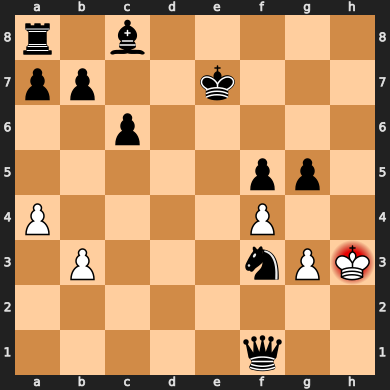

Player <Black> choosed the move: a1f1 with a value of 303560.5
Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)


In [12]:
result = play_game_live(Chess(), depth_white = 1,depth_black =1,  verbose=True)

# Heuristic and Algorithm Test
This cell is commented because it is used only during the test

In [13]:
#result = play_chess_games(Chess(), depth_white=1, depth_black=2, games_number=5, verbose=True)

In [14]:
#df = pd.DataFrame(result)
#df

In [15]:
#result = play_chess_games(Chess(), depth_white=1, depth_black=2, games_number=5, verbose=True)

In [16]:
#df = pd.DataFrame(result)
#df

# Homework 2 Predictive Min-Max
In the followind cells contain the core of the Machine learning code

- The framework used to implement the machine learning predictive MinMax is SciKit learn and the model used is the Multi-layer Perceptron regressor that is often used in supervised learning.

- The load_model(...) function: read the result stored in the csv and create, training and test sets and the create the model, in order to have a good quality of the prediction the parameter of the max_terations must bee setted  with at leas a value of 500, otherwise the model cant find a convergence and will not have good predictions.

- get_stored_moves(...) return a set of stored moves

- get_predictive_moves (...) it is similar to the old get_best_move() but it retrieve the moves by the get_stored_moves(...) instead use the game class that was based on the chess library

- predictive_alpha_beta () this function is similare to the other alpha_beta but in this case no moves will be recorded during the execution

- predictive_chess_games(...) this version of the function set a player with a normal set of actions based on the python-chess librare and the black player with the predictive model.


The full documentation of the MLPRegressor model can be found on the following link: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html


In [276]:

def load_model(color= 'Black',model_name = 'data.csv' ):
    
    df = pd.read_csv('data_big.csv', index_col=[0], names=[*SQUARE_NAMES, 'score','player'])

    df = df[df['player'] == color].drop('player', axis=1) # removes opponent's matches

    df_no_duplicates = df.drop_duplicates()

    X_train, X_test, y_train, y_test = train_test_split(
        df_no_duplicates.drop(columns='score'),
        df_no_duplicates['score']
    )

    model = MLPRegressor(max_iter=1000,hidden_layer_sizes=(len(SQUARE_NAMES), len(SQUARE_NAMES), len(SQUARE_NAMES)))
    

    return model.fit(X_train.values, y_train)



def get_stored_moves(game,state,model):
    prediced_moves = []
    for move in game.actions(state):
        new_state = game.result(state, move)
        values = get_board_values(game.get_board(state))
        pre = np.array(values).reshape(-1,64)
        value_p = model.predict(pre)
        prediced_moves.append((move, value_p))
    best_moves = sorted(prediced_moves, key=lambda x: x[1])[-10:] # sublist with the 10 best move and value
    return [best_moves[i][0] for i in range(len(best_moves))] # return a list with only moves

def get_predictive_move(game, state,depth,max_player, model):
    max_move = None
    max_eval = -np.inf
    heuristics=ChessHeuristics()
    for move in get_stored_moves(game,state,model):
        new_state = game.result(state, move)
        ev = alpha_beta_pruning(game,heuristics, new_state, depth - 1, -np.inf, np.inf, False)
        if ev > max_eval:
            max_eval = ev
            max_move = move
    #print ('BEST MOVE' + str (max_eval)+' PLAYER'+str (game.get_player(state)))      
    return max_eval, max_move


def predictive_alpha_beta (game,heuristics, state, depth, alpha, beta, max_player):
    if depth == 0 or game.is_terminal(state):
        return heuristics.h(game,state)
    
    if max_player:
        max_ev = -np.inf
        for move in game.actions(state):
            new_state = game.result(state,move)
            ev = alpha_beta_pruning(game,heuristics, new_state, depth-1, alpha, beta, False)
            max_ev = max(max_ev, ev)
            alpha = max(alpha, ev)
            if beta<= alpha:
                break
        
        return max_ev
    if not max_player:
        min_ev = np.inf
        for move in game.actions(state):
            new_state = game.result(state, move)
            ev = alpha_beta_pruning(game,heuristics, new_state, depth-1, alpha, beta, True)
            min_ev = min(min_ev, ev)
            beta = min(beta, ev)
            if beta <= alpha:
                break
        return min_ev



# Predictive Game Function (.....)
This function call the Standard MinMax function for the White Player and call The predictive MinMax function for The Black Player

In [277]:

def predictive_chess_games(game, depth_white,depth_black, games_number=50, update=False, verbose=True, model=''):    
    outcome_list = []

    for i in range(games_number):
        
        moves_number = 0
        t0 = time.time()
        state = game.initial
        if (verbose):
            print(f'Game {i} started')        
        while not game.is_terminal(state):
            player = game.get_player(state)
            if game.get_player(state)== 'White':
                #v,move = get_predictive_move(game, state,depth,max_player, model)
                v,move = get_best_move(game, state,depth_white,game.get_player(state))
            else:
                v,move = get_predictive_move(game, state,depth_black,game.get_player(state), model)
                #v,move = get_best_move(game, state,depth_black,game.get_player(state))
            state = game.result(state, move)
            moves_number += 1

        final_board = game.get_board(state)       
        t1 = time.time() - t0
        outcome_row = generate_df_row(depth_white,depth_black, final_board, t1, moves_number)
        outcome_list.append(outcome_row)

        if (verbose):
            print(f'Game {i} ended in {t1:.2f}s: {final_board.outcome()}')
            print('\n')
            #debug print
            #print(game.is_terminal(state))
        
        if (update):
            update_dataset()     
    return outcome_list

In [278]:
mod =  load_model("Black", "data_big.csv")

# Predictive Games Report

- Test: How we can se from the following result the black player using the predictive model with depth=2 usually win against a white player that has a depth=1 those gamse have been performed only as a test.
- White and Black (predictive) With same depth = 2 as result of those games we can highlight that the time elapsed is lower the the normal games because the black player does not explore all the possible moves but use the model.

In [22]:
predictive_result = predictive_chess_games(Chess(), depth_white=1,depth_black=2, games_number=5, update=False, verbose=True, model=mod)
df = pd.DataFrame(predictive_result)
df

Game 0 started
Game 0 ended in 11.71s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)


Game 1 started
Game 1 ended in 9.46s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)


Game 2 started
Game 2 ended in 8.19s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)


Game 3 started
Game 3 ended in 16.82s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)


Game 4 started
Game 4 ended in 8.66s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)




,White_Depth,Black_Depth,final_state,winner,termination,game_time(s),total_moves
0,1,2,5rkr/8/1p4p1/2pq2p1/1p1b2P1/PP4K1/2b1p2P/6r1 w...,Black,Termination.CHECKMATE,11.71,66
1,1,2,r4Bnr/8/pp6/8/P3p2P/4Pp2/3K1N1P/1kq5 w - - 0 41,Black,Termination.CHECKMATE,9.46,80
2,1,2,r1k3nr/6p1/pp5B/2p4p/P6P/4ppPR/1P3P2/RNr2KN1 w...,Black,Termination.CHECKMATE,8.19,48
3,1,2,4k1r1/4P3/8/3K4/8/1r6/pqr5/3qr1q1 w - - 0 94,Black,Termination.CHECKMATE,16.82,186
4,1,2,3k1bnr/8/1p6/5p2/N1P1pP2/PN1pp3/1P5p/R1B1K2r w...,Black,Termination.CHECKMATE,8.66,52


# Predictive Games with same depth = 2

As we can se the predictive player with the same deep have good performance against a normal alpha_beta player with the same depth this is strictly linked to the data used to build the model used.

In [21]:
predictive_result2 = predictive_chess_games(Chess(), depth_white=2,depth_black=2, games_number=5, update=False, verbose=True, model=mod)
df = pd.DataFrame(predictive_result2)
df

Game 0 started
Game 0 ended in 108.18s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)


Game 1 started
Game 1 ended in 52.65s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 2 started
Game 2 ended in 41.77s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)


Game 3 started
Game 3 ended in 67.55s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)


Game 4 started
Game 4 ended in 42.13s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)




,White_Depth,Black_Depth,final_state,winner,termination,game_time(s),total_moves
0,2,2,k2r3r/P4RP1/3bNP2/3p4/3Pb3/1p4p1/8/1r4K1 w - -...,Black,Termination.CHECKMATE,108.18,230
1,2,2,k2r3r/1Q6/3p2N1/1R6/2P5/Pp2b2P/1Pn4K/6r1 b - -...,White,Termination.CHECKMATE,52.65,75
2,2,2,4kb1r/2P1n1p1/2R3N1/5p2/1pP2P2/1p4pP/1Pp3P1/4r...,Black,Termination.CHECKMATE,41.77,50
3,2,2,r2q1rk1/2B3PR/1P6/8/1P6/4n1p1/8/2q3K1 w - - 0 44,Black,Termination.CHECKMATE,67.55,86
4,2,2,r1bqkQnr/8/1p4N1/1Np1B2p/5P1b/1P5P/1Pn1p1P1/3R...,White,Termination.CHECKMATE,42.13,47


# Statistics and Comparison

### Predictive Games: Black predictive player with depth = 3 Vs normal player with depth=1

- As shown in the following table with this setup the completion time of a game is close to 90 seconds

In [117]:
predictive_result_1_3 = predictive_chess_games(Chess(), depth_white=1,depth_black=3, games_number=30, update=False, verbose=True, model=mod)
df_1_3 = pd.DataFrame(predictive_result_1_3 )
df_1_3

Game 0 started
Game 0 ended in 52.03s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)


Game 1 started
Game 1 ended in 124.46s: Outcome(termination=<Termination.SEVENTYFIVE_MOVES: 4>, winner=None)


Game 2 started
Game 2 ended in 65.16s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)


Game 3 started
Game 3 ended in 54.72s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)


Game 4 started
Game 4 ended in 195.67s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)


Game 5 started
Game 5 ended in 58.17s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 6 started
Game 6 ended in 100.53s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)


Game 7 started
Game 7 ended in 31.74s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)


Game 8 started
Game 8 ended in 11.13s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 9 started
Game 9 ended in 137.24s: Outcome(termination=<Term

,White_Depth,Black_Depth,final_state,winner,termination,game_time(s),total_moves
0,1,3,rn1k1bnr/8/p2p4/1p1P3P/1PP5/K7/q3q3/8 w - - 0 32,Black,Termination.CHECKMATE,52.03,62
1,1,3,4k2r/P7/8/2p4p/2P1p2P/p7/r7/1K6 b - - 150 149,None,Termination.SEVENTYFIVE_MOVES,124.46,297
2,1,3,rn3b1r/7B/4Pk2/1p5K/1Pp5/P1P4q/3N4/8 w - - 10 40,Black,Termination.CHECKMATE,65.16,78
3,1,3,4kbnr/8/1pp2p2/5q1P/2P4P/8/1P2n1K1/3N1Bq1 w k ...,Black,Termination.CHECKMATE,54.72,44
4,1,3,3q4/3P4/5k1K/4N3/8/4r3/7q/8 w - - 5 147,Black,Termination.CHECKMATE,195.67,292
5,1,3,6Q1/8/2K1P2k/2b3P1/2P5/5B2/4P3/8 b - - 0 45,White,Termination.CHECKMATE,58.17,89
6,1,3,1K1k1bBr/P7/8/8/2p4p/2P5/1q4q1/8 w - - 1 60,Black,Termination.CHECKMATE,100.53,118
7,1,3,rnbqkbnr/6pp/2p5/3p1p2/ppKPp3/N7/PPP1PPPP/1RBQ...,Black,Termination.CHECKMATE,31.74,18
8,1,3,rnbq1bnr/p1pp1p1p/1p2p3/4PN2/2PPk2P/3B2p1/PP3P...,White,Termination.CHECKMATE,11.13,21
9,1,3,2K2k2/8/8/8/1p6/1P1B4/2q5/8 w - - 150 204,None,Termination.SEVENTYFIVE_MOVES,137.24,406


In [110]:
def average_ratio_move_time(df):
    moves=sum(df['total_moves'])
    times=sum(df['game_time(s)'].astype(float))
    ratio=times/moves
    return ratio
   

In [118]:
predictive_time=average_ratio_move_time(df_1_3)

### Predictive Games: Black predictive player with depth = 1 Vs normal player with depth=3

- As shown in the following table with this setup the completion time is very variable and it is always longer than the games that use the predictive model.

In [119]:
predictive_result_3_1 = predictive_chess_games(Chess(), depth_white=3,depth_black=1, games_number=30, update=False, verbose=True, model=mod)
df_3_1 = pd.DataFrame(predictive_result_3_1)
df_3_1

Game 0 started
Game 0 ended in 38.82s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 1 started
Game 1 ended in 208.12s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 2 started
Game 2 ended in 80.76s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 3 started
Game 3 ended in 77.06s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 4 started
Game 4 ended in 37.99s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 5 started
Game 5 ended in 100.77s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 6 started
Game 6 ended in 340.65s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 7 started
Game 7 ended in 109.89s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)


Game 8 started
Game 8 ended in 182.85s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 9 started
Game 9 ended in 73.53s: Outcome(termination=<Termination.CHEC

,White_Depth,Black_Depth,final_state,winner,termination,game_time(s),total_moves
0,3,1,rnbqkbnr/1p1p4/p5Q1/2pN1p2/4p3/1P2P1PN/P1PP1P1...,White,Termination.CHECKMATE,38.82,15
1,3,1,1k4R1/8/1BP5/4Pp2/5P2/8/2P3P1/3K4 b - - 6 64,White,Termination.CHECKMATE,208.12,127
2,3,1,r2qkb1r/3np3/3p1pQ1/p1p3pp/4P3/1P6/P1PP1PPP/RN...,White,Termination.CHECKMATE,80.76,27
3,3,1,1nbk1bnr/2q1pN2/r7/pB1p2p1/4P3/2P2pP1/pP1P1P1P...,White,Termination.CHECKMATE,77.06,33
4,3,1,rnbqkbnr/1pp2Q2/p5p1/3pppN1/4P3/8/PPPP1PPP/RNB...,White,Termination.CHECKMATE,37.99,11
5,3,1,3q1bnr/p3k3/n2p1Npp/1ppB2P1/4Q3/8/PP1PPP1P/R1B...,White,Termination.CHECKMATE,100.77,37
6,3,1,R3k3/7R/4N3/2P5/6p1/6P1/1P2p2P/4K3 b - - 1 53,White,Termination.CHECKMATE,340.65,105
7,3,1,r2k1N1r/p1pbn1p1/8/8/2p5/8/PPPP1PPP/RNB1r1KR w...,Black,Termination.CHECKMATE,109.89,34
8,3,1,8/Q7/k1Np2p1/6b1/2P1pp2/3r4/1P1P1PP1/2B2KR1 b ...,White,Termination.CHECKMATE,182.85,73
9,3,1,rn1Qkbnr/5p2/p1p5/1p2P1Bp/4N3/P1N4b/1PP1PPPP/R...,White,Termination.CHECKMATE,73.53,19


# Plot Functions

In [122]:
standard_time=average_ratio_move_time(df_3_1)

In [258]:
import matplotlib.pyplot as plt

def plot_bar_chart(time_pred, time_standard):
    plt.rcParams["figure.figsize"] = (15,5)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    print("Predictive Time per Move: "+str(time_pred))
    print("Standard Time per Move: "+str(time_standard))
    ratio_times=time_standard//time_pred
    print("The Predictive Min-Max is "+str(ratio_times)+" times fastest")
    x_values = ['Predictive MinMax','Standard MinMax']
    y_values = [time_pred,time_standard]
    ax.bar(x_values,y_values)
    plt.show()

def win_ratio(df,player,opponent):
    games=df['winner']
    player_win=df[df['winner'] == player]
    opponent_win=df[df['winner'] == opponent]
    draw = len(games)-len(player_win)-len(opponent_win)
    games=len(df)
    ratio=(len( player_win)/games)*100
    draw_ratio=(draw/games)*100
    #print("win ratio for the "+str (player)+" is: "+str(ratio)+ "| Draw Ratio:"+str(draw_ratio)+"%")
    return ratio

def draw_ratio(df,player,opponent):
    games=df['winner']
    player_win=df[df['winner'] == player]
    opponent_win=df[df['winner'] == opponent]
    draw = len(games)-len(player_win)-len(opponent_win)
    games=len(df)
    draw_ratio=(draw/games)*100
    #print("Draw Ratio:"+str(draw_ratio)+"%")
    return draw_ratio

def loss_ratio(df,player,opponent):
    games=df['winner']
    player_lose=df[df['winner'] == opponent]
    games=len(df)
    ratio=(len( player_lose)/games)*100
    #print("Lose ratio for the "+str (player)+" is: "+str(ratio)+ "%")
    return ratio

def plot_accuracy_bar_chart(accuracy_predictive, accuracy_standard, result_name):
    plt.rcParams["figure.figsize"] = (15,5)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    print(str(result_name)+": Predictive MinMax Accuracy: "+str(accuracy_predictive)+"%")
    print(str(result_name)+": Standard MinMax Accuracy: "+str(accuracy_standard)+"%")
    x_values = ['Predictive MinMax','Standard MinMax']
    y_values = [accuracy_predictive,accuracy_standard]
    ax.bar(x_values,y_values)
    plt.show()

## Comparison Between the time of the Standard MinMax and the Predictive MinMax for 60 matches
In order to make this comparison the program runned 30 matches with a standard MinMax with depth=3 and 30 matches with a Predictive MinMax with depth=3, the other player in both cases has a depth=1 in order to be fast as possible with the purpose to ignore the time of the depth1 player and make a good comparison between the predictive-MinMax at depth = 3 and the Standard-MinMax at depth=3

## Time Comparison

Predictive Time per Move: 0.5519295090811005
Standard Time per Move: 2.3427106017191974
The Predictive Min-Max is 4.0 times fastest


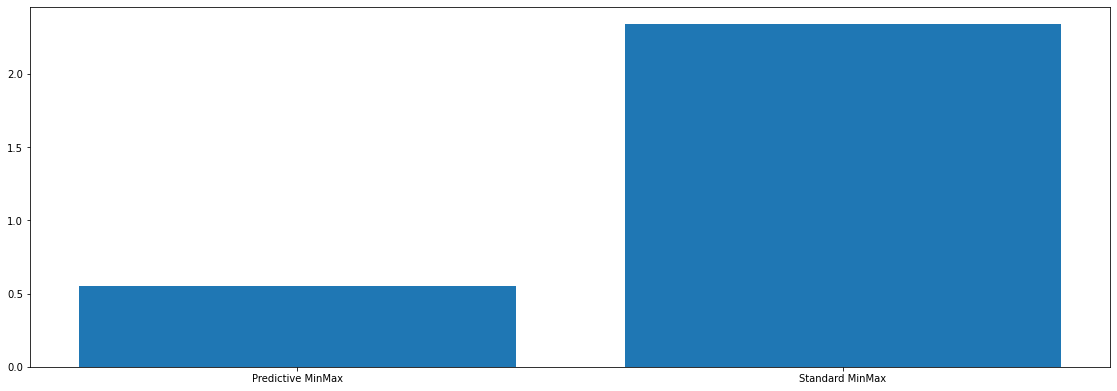

In [259]:
plot_bar_chart(predictive_time, standard_time)

## Win Comparison

WINS: Predictive MinMax Accuracy: 56.666666666666664%
WINS: Standard MinMax Accuracy: 86.66666666666667%


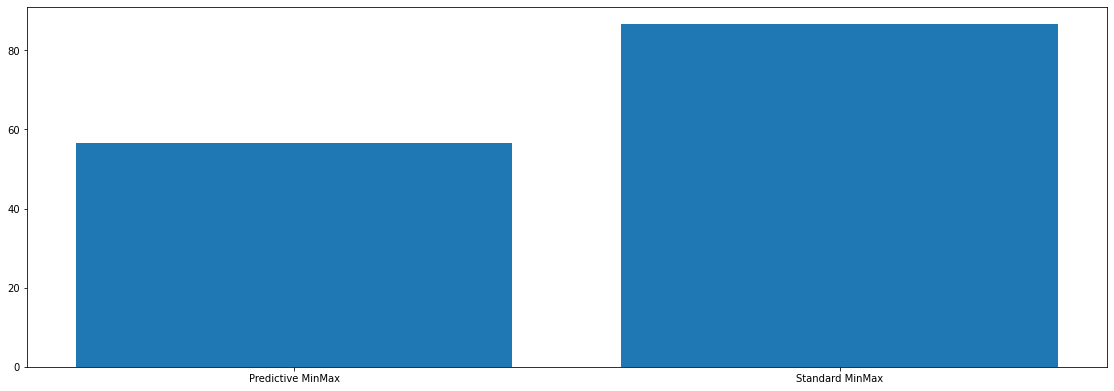

In [260]:
plot_accuracy_bar_chart(win_ratio(df_1_3,"Black","White"), win_ratio(df_3_1,"White","Black"), "WINS")

## Loss Comparison

LOSS: Predictive MinMax Accuracy: 10.0%
LOSS: Standard MinMax Accuracy: 10.0%


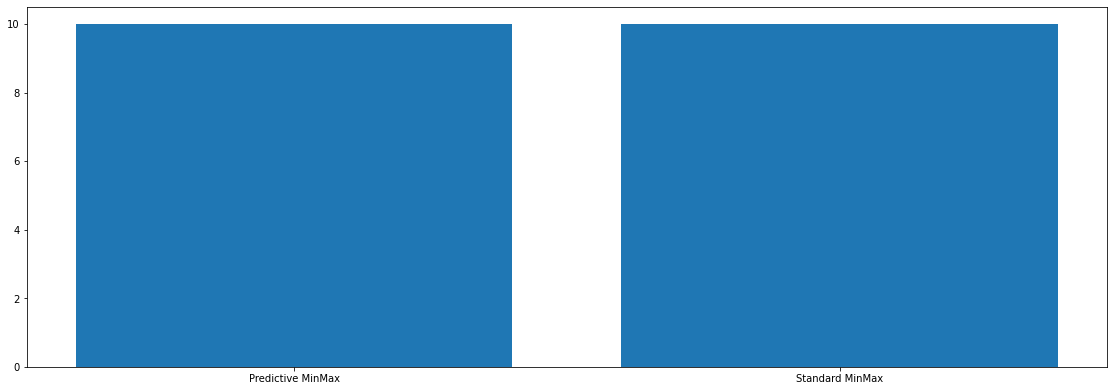

In [261]:
plot_accuracy_bar_chart(loss_ratio(df_1_3,"Black","White"), loss_ratio(df_3_1,"White","Black"),"LOSS")

## Draw Comparison

Draw: Predictive MinMax Accuracy: 33.33333333333333%
Draw: Standard MinMax Accuracy: 3.3333333333333335%


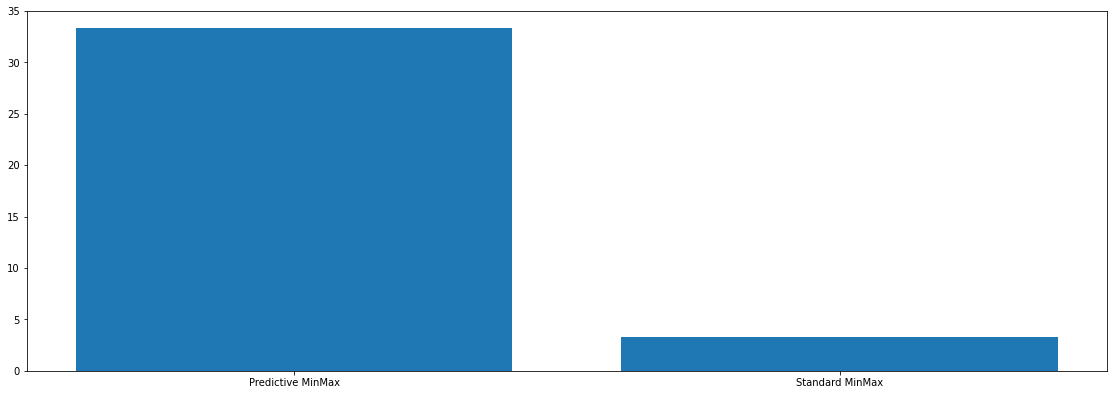

In [262]:
plot_accuracy_bar_chart(draw_ratio(df_1_3,"Black","White"), draw_ratio(df_3_1,"White","Black"),"Draw")

In [282]:
predictive_result_3_3 = predictive_chess_games(Chess(), depth_white=3,depth_black=3, games_number=30, update=False, verbose=True, model=mod)
df_3_3 = pd.DataFrame(predictive_result_3_3)
df_3_3

Game 0 started
Game 0 ended in 67.10s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 1 started
Game 1 ended in 114.58s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 2 started
Game 2 ended in 135.45s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 3 started
Game 3 ended in 197.55s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)


Game 4 started
Game 4 ended in 281.06s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)


Game 5 started
Game 5 ended in 103.63s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 6 started
Game 6 ended in 104.40s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)


Game 7 started
Game 7 ended in 123.74s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 8 started
Game 8 ended in 301.21s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 9 started
Game 9 ended in 105.17s: Outcome(termination=<Terminatio

,White_Depth,Black_Depth,final_state,winner,termination,game_time(s),total_moves
0,3,3,rnQk1bnr/1p2q1pp/p1pN4/4p3/3p4/4P3/PPPP1PPP/RN...,White,Termination.CHECKMATE,67.10,15
1,3,3,rnb2Qnr/3q3p/1p2pNk1/3p2p1/8/2PBp1P1/PP1P1P1P/...,White,Termination.CHECKMATE,114.58,27
2,3,3,8/1p6/2p3p1/4RkB1/5P2/2Pp3P/8/2K5 b - - 1 29,White,Termination.CHECKMATE,135.45,57
3,3,3,8/8/8/2p5/2Pp4/3p4/2r4k/1q2K3 w - - 0 95,Black,Termination.CHECKMATE,197.55,188
4,3,3,3k1b1r/3Pq3/4P1b1/6P1/4r3/6n1/7q/6K1 w - - 1 124,Black,Termination.CHECKMATE,281.06,246
5,3,3,rn1Qkbnr/1b3p2/4N1p1/1p2p3/2pP4/8/PP2PPPP/RNB1...,White,Termination.CHECKMATE,103.63,23
6,3,3,1nbq1b1r/2p2k2/1p2pnp1/1N1P4/8/4P3/1P1P1PPP/4r...,Black,Termination.CHECKMATE,104.40,28
7,3,3,7r/5Q1k/1pp3pp/4pp2/8/1P6/P1PPPPPP/R2K1BNR b -...,White,Termination.CHECKMATE,123.74,37
8,3,3,k7/7R/8/1p1BB3/1Pp5/2P3p1/2P4p/7K b - - 1 58,White,Termination.CHECKMATE,301.21,115
9,3,3,rn1q1bkr/2p1p1pp/pp2Qn2/3B2N1/5p2/4P3/PPPP1PPP...,White,Termination.CHECKMATE,105.17,21


WINS: Predictive MinMax Accuracy: 33.33333333333333%
WINS: Standard MinMax Accuracy: 50.0%


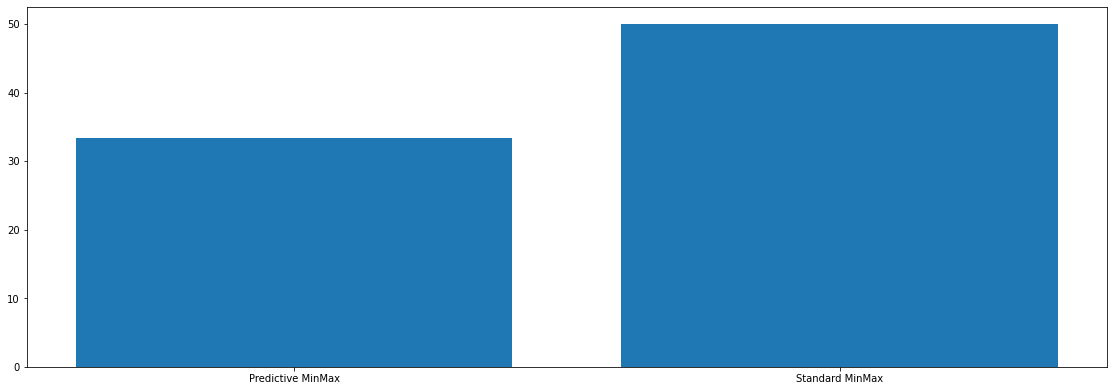

In [283]:
plot_accuracy_bar_chart(win_ratio(df_3_3,"Black","White"), win_ratio(df_3_3,"White","Black"), "WINS")

# Conclusion


- By the previous result a Predictive MinMax can perform a move with an average of 0.5 second while the Standard MinMax can perform a move with an average of 2.4second.
- The Predictive Agent depth=3 has a win rate of 56.6%, loss rate of 10% and 33.3% of draw games.
- The Standard MinMax Agent with depth=3 has a win rate of 86,6%,  a loss rate of 10% and only 3.3% of draw games.
- The Predictive Agent at depth 3 vs the Standard Agent at Depth 3 has 33% probability to win and 50% of Loss this is an expected result because the standard MinManx is an exhaustive search and end explore all the possible moves meanwhile the moves of the predictive MinMax are generated by a predictive Model.



In conclusion the machine Learning approach allows to reduce the execution times of the games, this happens because the agent that use the predictive model does not explore all the nodes, but the Standard MinMax agent has better result in term winning rate.
The goodness of results returned by the predictive model is stritly linked to the data used to build the model. In this homework has been used a 18MB .csv with more than 118.400 entry.  this allowed to build a good predictive model that perform good results.
